In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from astropy.cosmology import default_cosmology

from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.Util import data_util

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import lenstronomy_sim, survey_sim

In [2]:
pickle_path = os.path.join(config.machine.dir_00, 'detectable_gglenses_00.pkl')  # detectable_gglenses_01
detectable_gglenses = util.unpickle(pickle_path)

print(f'{len(detectable_gglenses)} detectable lens(es)')

110 detectable lens(es)


In [3]:
bands = ['F106', 'F129', 'F184']

sample_gglens = np.random.choice(detectable_gglenses)
# sample_gglens = detectable_gglenses[0]
sample_lens = lens_util.slsim_lens_to_mejiro(sample_gglens, bands=bands, cosmo=default_cosmology.get())

pprint(sample_lens.lens_mags)
pprint(sample_lens.source_mags)

{'F106': 19.97818780510448,
 'F129': 19.774160698546392,
 'F184': 19.439149570408684}
{'F106': 22.9075471922012, 'F129': 22.19680175170319, 'F184': 21.52765158451985}


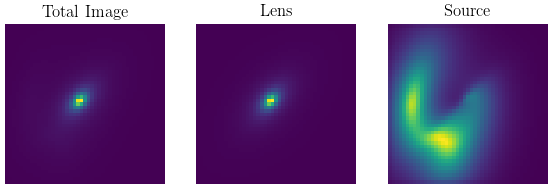

In [9]:
total_image, lens_surface_brightness, source_surface_brightness, sim_r = survey_sim.get_image(sample_gglens, band=bands[1], side=4.95)

f, ax = plt.subplots(1, 3)
ax[0].imshow(total_image)
ax[0].set_title('Total Image')
ax[1].imshow(lens_surface_brightness)
ax[1].set_title('Lens')
ax[2].imshow(source_surface_brightness)
ax[2].set_title('Source')
for a in ax: a.axis('off')
plt.show()

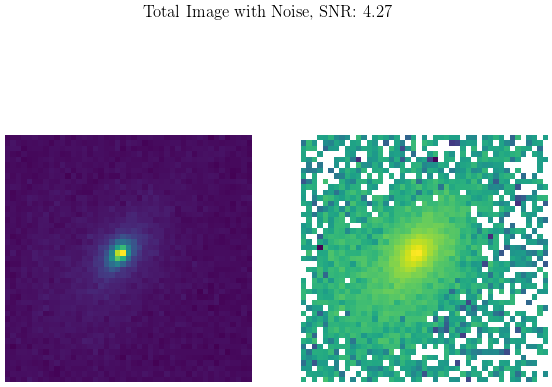

In [10]:
snr, total_image_with_noise = survey_sim.get_snr(sample_gglens, band=bands[1], mask_mult=1, side=4.95)

f, ax = plt.subplots(1, 2)
ax[0].imshow(total_image_with_noise)
ax[1].imshow(np.log10(total_image_with_noise))
for a in ax: a.axis('off')
plt.suptitle(f'Total Image with Noise, SNR: {snr:.2f}')
plt.show()

In [4]:
import mejiro
from mejiro.helpers.roman_params import RomanParameters

module_path = os.path.dirname(mejiro.__file__)
csv_path = os.path.join(module_path, 'data', 'roman_spacecraft_and_instrument_parameters.csv')
roman_params = RomanParameters(csv_path)

In [5]:
gglens = sample_gglens

kwargs_model, kwargs_params = gglens.lenstronomy_kwargs(band=band)

pprint(kwargs_params)
# pprint(kwargs_model)

{'kwargs_lens': [{'center_x': 0.07843121295183719,
                  'center_y': 0.07744921201460564,
                  'e1': 0.5324816680907589,
                  'e2': 0.07843195434617711,
                  'theta_E': 0.7550442482859725},
                 {'dec_0': 0,
                  'gamma1': -0.11975473498932485,
                  'gamma2': 0.008882734840183551,
                  'ra_0': 0},
                 {'dec_0': 0, 'kappa': 0.00530299012016576, 'ra_0': 0}],
 'kwargs_lens_light': [{'R_sersic': 0.4768881011399557,
                        'center_x': 0.07843121295183719,
                        'center_y': 0.07744921201460564,
                        'e1': 0.241245291050533,
                        'e2': -0.0210842752551561,
                        'magnitude': 19.07621095236832,
                        'n_sersic': 4.0}],
 'kwargs_ps': None,
 'kwargs_source': [{'R_sersic': 0.23988768272711591,
                    'center_x': 0.28111897526473184,
                    'center_y':

In [6]:
from copy import deepcopy

from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.SimulationAPI.sim_api import SimAPI

gglens = sample_gglens
side = 4.95

kwargs_model, kwargs_params = gglens.lenstronomy_kwargs(band=band)

Roman_r = Roman.Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area')
# pprint(Roman_r.obs)
Roman_r.obs['num_exposures'] = 1
kwargs_r_band = Roman_r.kwargs_single_band()
pprint(Roman_r.obs)

sim_r = SimAPI(numpix=int(side / 0.11), kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)

kwargs_numerics = {'point_source_supersampling_factor': 1, 'supersampling_factor': 3}
imSim_r = sim_r.image_model_class(kwargs_numerics)

kwargs_lens = kwargs_params['kwargs_lens']
kwargs_lens_light = kwargs_params['kwargs_lens_light']
kwargs_source = kwargs_params['kwargs_source']

kwargs_lens_light_r, kwargs_source_r, _ = sim_r.magnitude2amplitude(kwargs_lens_light, kwargs_source)

# set lens light to 0 for source image
source_kwargs_lens_light_r = deepcopy(kwargs_lens_light_r)
source_kwargs_lens_light_r[0]['amp'] = 0
source_surface_brightness = imSim_r.image(kwargs_lens, kwargs_source_r, source_kwargs_lens_light_r, None)

# set source light to 0 for lens image
lens_kwargs_source_r = deepcopy(kwargs_source_r)
lens_kwargs_source_r[0]['amp'] = 0
lens_surface_brightness = imSim_r.image(kwargs_lens, lens_kwargs_source_r, kwargs_lens_light_r, None)

total_image = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, None)
# total_image += sim_r.noise_for_model(model=total_image)

{'exposure_time': 146,
 'kernel_point_source': array([[3.63835275e-08, 8.68507206e-08, 1.38956763e-07, ...,
        1.17150099e-07, 6.72888589e-08, 2.92235160e-08],
       [1.88676583e-08, 4.65740154e-08, 1.10142828e-07, ...,
        8.49029955e-08, 3.58424164e-08, 1.70454248e-08],
       [2.03553968e-08, 2.17990189e-08, 5.63696037e-08, ...,
        4.31937530e-08, 2.02864153e-08, 1.97635464e-08],
       ...,
       [2.03629666e-08, 6.40347870e-08, 1.33681784e-07, ...,
        8.61007263e-08, 3.34592850e-08, 1.42907123e-08],
       [5.29207824e-08, 1.07030649e-07, 1.37998434e-07, ...,
        1.28316370e-07, 7.03423560e-08, 2.73229793e-08],
       [8.86792264e-08, 1.12878395e-07, 9.54914212e-08, ...,
        1.22316426e-07, 1.01706884e-07, 5.60483170e-08]]),
 'magnitude_zero_point': 26.44,
 'num_exposures': 1,
 'psf_type': 'PIXEL',
 'seeing': 0.087,
 'sky_brightness': 22.99}


In [24]:
mask_mult = 0.5
zodi_mult = 1.5

# calculate region for source surface brightness array and count signal
stdev = np.std(source_surface_brightness)
mean = np.mean(source_surface_brightness)
mask = source_surface_brightness < mean + (mask_mult * stdev)
masked_source = np.ma.masked_array(source_surface_brightness, mask=mask)
sum_source_counts = np.sum(masked_source)

# get min zodiacal light and thermal background for given band
min_zodiacal_light = roman_params.get_min_zodi_count_rate(band)
thermal_background = roman_params.get_thermal_bkg(band)

# estimate and add background
estimated_background = (min_zodiacal_light * zodi_mult) + thermal_background  # in counts/pixel
estimated_background *= np.ones(total_image.shape)
total_image += estimated_background

# add noise
noise = sim_r.noise_for_model(model=total_image)
total_image += noise

# count total signal
masked_total = np.ma.masked_array(total_image, mask=mask)
sum_total_counts = np.sum(masked_total)

# calculate estimated SNR
snr = sum_source_counts / np.sqrt(sum_total_counts)
print(f'SNR: {snr}')

SNR: 10.539485777390603


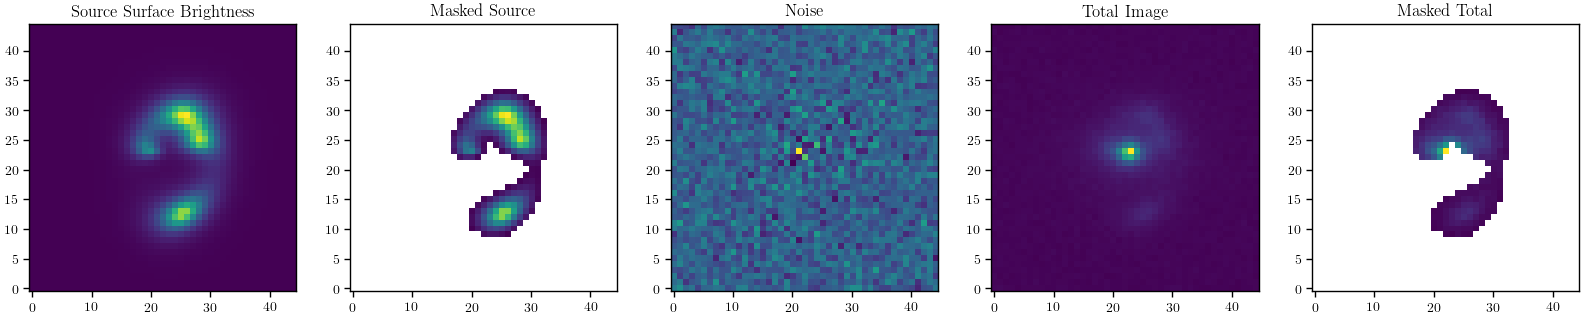

In [25]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))

ax[0].imshow(source_surface_brightness)
ax[1].imshow(masked_source)
ax[2].imshow(noise)
ax[3].imshow(total_image)
ax[4].imshow(masked_total)

ax[0].set_title('Source Surface Brightness')
ax[1].set_title('Masked Source')
ax[2].set_title('Noise')
ax[3].set_title('Total Image')
ax[4].set_title('Masked Total')

plt.show()

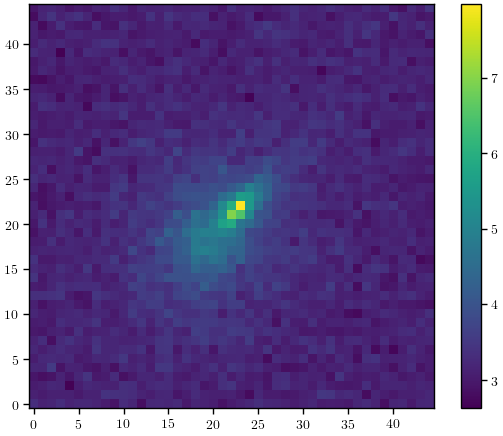

In [26]:
# get mejiro image
image_path = os.path.join(config.machine.dir_04, 'galsim_00000000_F106.npy')
mejiro_image = np.load(image_path)
mejiro_image = util.center_crop_image(mejiro_image, (45, 45))

plt.imshow(mejiro_image)
plt.colorbar()
plt.show()

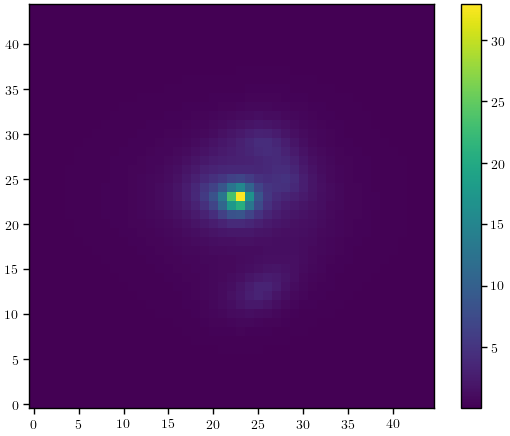

In [27]:
from mejiro.helpers import survey_sim

total_image, _, source_surface_brightness, sim_api = survey_sim.get_image(sample_gglens, band, side=side)

plt.imshow(total_image)
plt.colorbar()
plt.show()

check that the units of the array from lenstronomy simapi are counts/sec/pixel by checking against noiseless image sum of array

In [28]:
lens_flux_cps = sample_lens.get_lens_flux_cps(band)
source_flux_cps = sample_lens.get_source_flux_cps(band)
total_flux_cps = sample_lens.get_total_flux_cps(band)

print(lens_flux_cps, source_flux_cps)
print(total_flux_cps)
print(np.sum(total_image))

assert np.allclose(total_flux_cps, np.sum(total_image)) == True

882.0955254242168 76.33314052979134
958.4286659540081
1146.4913687830199


AssertionError: 

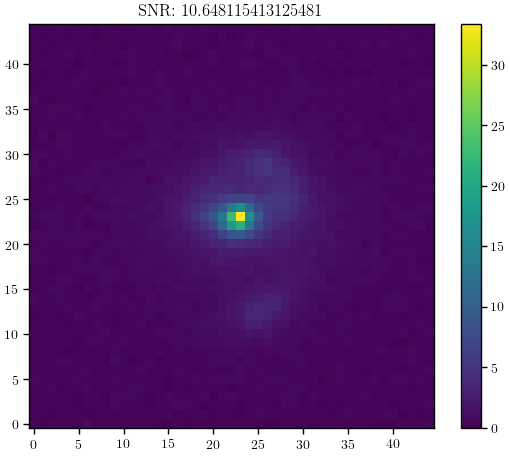

In [29]:
snr, total_image_with_noise = survey_sim.get_snr(sample_gglens, band)

plt.imshow(total_image_with_noise)
plt.title(f'SNR: {snr}')
plt.colorbar()
plt.show()

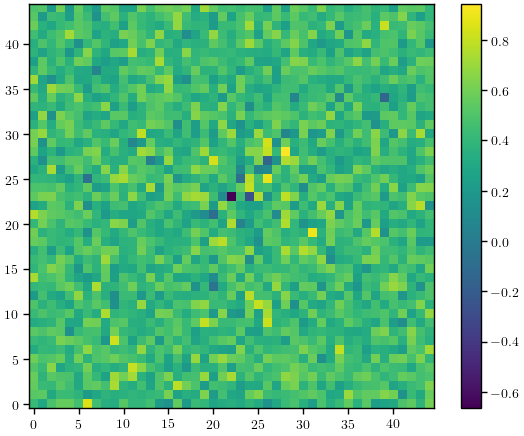

In [30]:
plt.imshow(total_image_with_noise - total_image)
plt.colorbar()
plt.show()